Tutorial 4: Integration and Analysis of Multimodal Data
=======================================================

In Tutorial 2, we showed how to use the Laplacian score to determine if a feature (genetic mutations, gene expression, etc.) varies non-randomly throughout the morphology space. Here, we demonstrate other techniques implemented in CAJAL to relate morphological distances to other data modalities. For that purpose, we are going to perform an integrative analysis of the Patch-seq data from 645 neurons from the mouse motor cortex. Patch-seq provides concurrent morphological, electrophysiological, and transcriptomic profiling of individual cells. The source data for this example can be found in this [folder](https://www.dropbox.com/scl/fo/ocyckc6iodvulh0cqikyy/AMaqIXjF64F3OpxtnfEX8Cc?rlkey=z4y5e291v5zgwfgtgi34ujrav&dl=0). More information about this dataset can be found in:

\- Scala, F. et al. [Phenotypic variation of transcriptomic cell types in mouse motor cortex.](https://www.nature.com/articles/s41586-020-2907-3) Nature 598, 144-150 (2021).

Each data modality (transcriptomic, electrophysiology, and morphology) leads to a different notion of similarity between cells. Hence, we can think of three different manifestations of the cell space, where the notion of distance in each space reflects one aspect of the cell. We refer to these three manifestations as the morphology space, the electrophysiology space, and the gene expression space. In the first part of this tutorial, we are going to identify inconsistencies between these spaces. For example, morphological variability that is not accompanied by consistent electrophysiological and transcriptomic variability, etc.

We will assume that the data is located in the folder `/home/jovyan/`.

In [1]:
bd = '/home/patn/dropbox/Data/Scala'

We first compute the intracellular distance matrices and the Gromov-Wasserstein distance between each pair of neurons, as described in Tutorial 1.

In [2]:
import cajal.sample_swc
import cajal.swc
from os.path import join

cajal.sample_swc.compute_icdm_all_geodesic(
    infolder=join(bd,'swc'),
    out_csv=join(bd,'geodesic_100_icdm.csv'),
    out_node_types=join(bd,"geodesic_100_node_types.npy"),
    n_sample=100,
    num_processes=8,  # num_processes can be set to the number of cores on your machine
    preprocess=cajal.swc.preprocessor_geo([1,3,4])
)

100%|█████████▉| 644/645 [00:28<00:00, 22.84it/s]


[]

In [3]:
import cajal.run_gw

cajal.run_gw.compute_gw_distance_matrix(
    intracell_csv_loc=join(bd,'geodesic_100_icdm.csv'),
    gw_dist_csv_loc=join(bd,'geodesic_100_gw.csv'),
    num_processes=14  # num_processes can be set to the number of cores on your machine
)

  0%|          | 0/207690 [00:00<?, ?it/s]

(array([[  0.        ,  90.35395787,  57.40921687, ..., 111.36903553,
         158.42433906,  81.89420297],
        [ 90.35395787,   0.        ,  58.70649113, ...,  55.50974471,
          85.79612715, 125.12599458],
        [ 57.40921687,  58.70649113,   0.        , ...,  82.73578656,
         123.84900436,  97.49961485],
        ...,
        [111.36903553,  55.50974471,  82.73578656, ...,   0.        ,
          82.60915725, 159.82301257],
        [158.42433906,  85.79612715, 123.84900436, ...,  82.60915725,
           0.        , 194.52567996],
        [ 81.89420297, 125.12599458,  97.49961485, ..., 159.82301257,
         194.52567996,   0.        ]]),
 None)

Next, we parse the electrophysiology and gene expression data, along with the metadata for each cell.

In [4]:
import pandas as pd

ephys_data = pd.read_csv(join(bd,'ephys_data.csv'),index_col='cell id')
exon_data = pd.read_csv(join(bd,'exon_data.csv'),index_col='cell id')
metadata = pd.read_csv(join(bd,"m1_patchseq_meta_data.csv"), delimiter="\t", index_col=1)

We restrict our analysis to cells for which we have all three types of data: morphological, transcriptomic, and electrophysiological.

In [5]:
import cajal.utilities

cells, gw_dist_dict = cajal.utilities.read_gw_dists(join(bd,'geodesic_100_gw.csv'),header=True)

common_cells = list(set(cells).intersection(exon_data.index).intersection(ephys_data.index))
metadata = metadata.loc[common_cells]
exon_data = exon_data.loc[common_cells]
ephys_data = ephys_data.loc[common_cells]

We standardize each electrophysiological feature and define the electrophysiological dissimilarity between cells as the Pearson's correlation distance between their vectors of electrophysiological features.

In [6]:
ephys_data = (ephys_data - ephys_data.mean())
ephys_data /= ephys_data.std()
ephys_dmat = (1-ephys_data.transpose().corr())

As with the electrophysiology data, we use correlation distance as our measure of dissimilarity between samples, applying log(1 + c CPM) normalization to the gene expression values.

In [7]:
import numpy as np

exon_data = np.log(5000 * exon_data + 1)
exon_dmat = 1-(exon_data.transpose().corr(method='pearson'))

The function `cajal.ternary.ternary_distance_clusters()` can be used to visualize the consistency between the morphological, electrophysiological, and transcriptomic distance matrices. For each pair of cells, a point is represented in a ternary plot, where the three axes correspond to the differences between (standardized) transcriptomic and electrophysiology (T-E), electrophysiology and morphology (E-M), and morphology and transcriptomic (M-T) distances. If the standardized distances between a pair of cells are consistent in the morphology, electrophysiology, and gene expression spaces, the corresponding point will appear in the center of the ternary plot. Deviations from the center indicate an imbalance in the distances corresponding to one or more data modalities. By plotting each cellular population separately, we can identify cell populations for which there is a deficit or excess of variability in the transcriptomic, electrophysiology, and/or morphology spaces.

`cajal.ternary.ternary_distance_clusters()` takes as input the electrophysiology, morphology, and transcriptomic pairwise distance matrices, the parameters of a smoothing kernel for visualization, and the labels of the cell populations to plot them separately.

(<Figure size 400x2800 with 7 Axes>,
  <matplotlib.tri._tricontour.TriContourSet at 0x7f4693a2c830>])

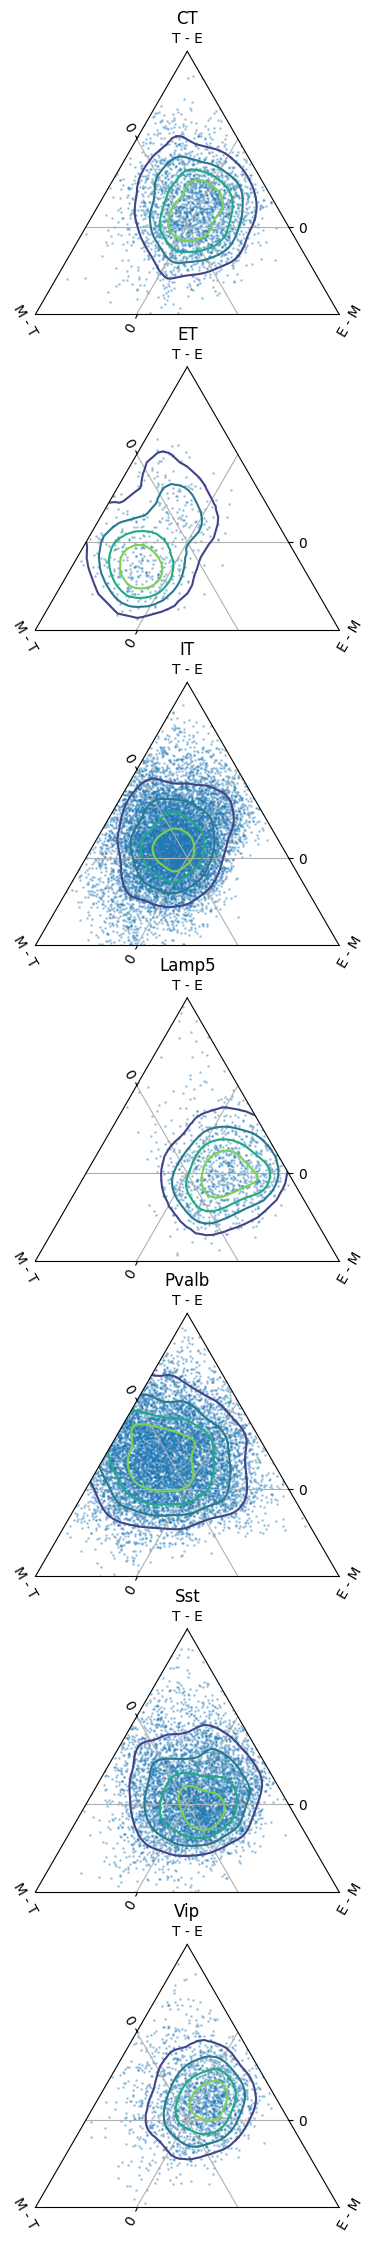

In [8]:
import cajal.ternary

gw_dmat = cajal.utilities.dist_mat_of_dict(gw_dist_dict,common_cells)

cajal.ternary.ternary_distance_clusters(
    exon_dmat.to_numpy(),
    'T', # Transcriptomic
    ephys_dmat.to_numpy(),
    'E', # Electrophysiological
    gw_dmat,
    'M', # Morphological
    density_estimation = 'gaussian_kde',
    clusters = metadata['RNA family'].to_numpy(),
)

We observe imbalances in several populations. For example, extratelencephalic (ET) excitatory neurons have morphological variability that is not accompanied by transcriptomic variability, skewing the distribution in the ternary plot towards positive values of M-T. This is possibly a consequence of local transcription programs at distant dendrites, which are not captured by nuclear gene expression profiling in Patch-seq. Similarly, <i>Lamp5</i>+ GABAergic neurons present limited morphological and electrophysiological variability compared to their transcriptomic variability.

Having quantified the consistency between the morphology, electrophysiology, and gene expression spaces, we will now build a consolidated space that integrates information from the three modalities. For this purpose, CAJAL uses the Weighted Nearest Neighbors (WNN) algorithm introduced in:

\- Hao, Y. et al. [Integrated analysis of multimodal single-cell data.](https://www.sciencedirect.com/science/article/pii/S0092867421005833) Cell 184, 3573-3587 (2021).

The relative influence of each of the three spaces in the consolidated space varies throughout the space and is locally biased at any point toward the spaces that are contributing more information in a neighborhood of that point. Because the WNN algorithm was designed for Euclidean spaces, CAJAL represents the Gromov-Wasserstein space as a metric subspace of a Euclidean space of the same intrinsic dimension of the data using the Isomap embedding and the Manifold-Adaptive Dimension Estimation (MADA) (Farahmand et al. IMLS 2007).

Before introducing WNN, let us look at the morphology space and the transcriptomic space separately. We build the gene expression latent space using [Scanpy](https://scanpy.readthedocs.io/en/stable/). For this purpose, we perform log(1 + c CPM) normalization and build a PCA space using the top 2,000 variable genes and 50 principal components.

In [9]:
import scanpy as sc
from scipy.spatial.distance import squareform, pdist

adata = sc.read_csv(join(bd,'exon_data.csv'))

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata)
indices = np.array([adata.obs.index.get_loc(index) for index in common_cells])
X_pca = adata.obsm['X_pca'][indices]

transcriptome_dmat = squareform(pdist(X_pca))

Similarly, we construct the electrophysiology latent space following the approach described in Scala et al., Nature 598 (2021). This involves deleting unused electrophysiology variables and normalizing each column to have the same variance.

In [10]:
ephys_data = pd.read_csv(join(bd,'ephys_data.csv'),index_col='cell id')
remove_columns = [ 'Afterdepolarization (mV)', 'Burstiness', 'Rebound number of APs', 'Sag area (mV*s)', 'Sag time (s)',
                  'Wildness', 'AP Fano factor',  'Latency @ +20pA current (ms)', 'ISI Fano factor', 'AP amplitude average adaptation index', 'ISI average adaptation index', 'Spike frequency adaptation']
ephys_data = ephys_data.drop(columns = remove_columns)
for column in ['AP coefficient of variation', 'ISI coefficient of variation','ISI adaptation index', 'Latency (ms)']:
    assert np.all(ephys_data[column]>0)
    ephys_data[column] = ephys_data[column].apply(np.log)
for col in ephys_data.columns:
    ephys_data[col] /= np.std(ephys_data[col])

ephys_data= ephys_data.loc[common_cells].values
ephys_dmat = squareform(pdist(ephys_data))

In addition to the neuronal RNA types from the original paper, we can introduce neuronal morphological and electrophysiological types by applying the Louvain clustering algorithm to the corresponding spaces.

In [11]:
morphology_labels = cajal.utilities.louvain_clustering(gw_dmat, 10)
ephys_labels = cajal.utilities.louvain_clustering(squareform(pdist(ephys_data)), 10)
RNA_family = metadata['RNA family'].values

As expected, the morphology types are highly localized in the morphology space, while the RNA and electrophysiology types show only a moderate degree of localization in the morphology space.

In [12]:
import plotly.io as pio

# Choose the adequate plotly renderer for visualizing plotly graphs in your system
pio.renderers.default = 'notebook_connected'
#pio.renderers.default = 'iframe'

import umap
import plotly.express
import plotly.subplots

def plot_space(mat, tit):
    fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=("Morphology types", "RNA types", "Electrophysiology types"))

    # Compute UMAP representation
    embedding = umap.UMAP(metric="precomputed", random_state=1).fit_transform(mat)

    # Visualize UMAP
    figs = [plotly.express.scatter(x=embedding[:,0],
                           y=embedding[:,1],
                           hover_name=[m + ".swc" for m in common_cells],
                           color = [str(m) for m in l])
            for l in [morphology_labels, RNA_family, ephys_labels]]

    for n, f in enumerate(figs):
        for i in f.data:
            fig.add_trace(i, row=1, col=n+1)

    fig.update_layout(showlegend=False, title = tit, template="simple_white")
    fig.show()

plot_space(gw_dmat, "Morphology Space")

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version 

Similarly, the RNA types are highly localized in the gene expression space, while the morphology and electrophysiology types show only a moderate degree of localization in this space.

In [13]:
plot_space(transcriptome_dmat, "Gene Expression Space")

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version 

And the electrophysiology types are highly localized in the electrophysiology space, while the morphology and RNA types show only a moderate degree of localization in this space.

In [14]:
plot_space(ephys_dmat, "Electrophysiology Space")

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version 

To quantify the degree to which each space preserves information about the transcriptomic, morphology, and electrophysiology types, we train nearest-neighbors classifiers on each of the distance matrices and evaluate their accuracy using the Matthews correlation coefficient (MCC) and 7-fold cross-validation. The results are consistent with the qualitative intuitions gained from the above UMAP visualizations.

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import matthews_corrcoef
from sklearn.neighbors import KNeighborsClassifier

def test_space(mat):
    clf = KNeighborsClassifier(metric="precomputed", n_neighbors=10, weights="distance")
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=0)

    cvp_m = cross_val_predict(clf, X=mat, y=morphology_labels, cv=cv)
    cvp_t = cross_val_predict(clf, X=mat, y=RNA_family, cv=cv)
    cvp_e = cross_val_predict(clf, X=mat, y=ephys_labels, cv=cv)

    return(pd.DataFrame({"M types" : [matthews_corrcoef(cvp_m, morphology_labels)],
          "T types" : [matthews_corrcoef(cvp_t, RNA_family)],
          "E types" : [matthews_corrcoef(cvp_e, ephys_labels)]}))

df = pd.concat([test_space(gw_dmat), test_space(transcriptome_dmat), test_space(ephys_dmat)])
df.index = pd.Index(["Morphology space", "Gene expression space", "Electrophysiology space"])
df

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=7.

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=7.

/home/patn/PGC012_Gromov_Wasserstein/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=7.



,M types,T types,E types
Morphology space,0.928840,0.387896,0.204938
Gene expression space,0.289321,0.867943,0.441320
Electrophysiology space,0.293602,0.779097,0.932610


The excellent MCC of each type in their corresponding space is somewhat tautological, as the types are constructed from clustering the high-dimensional space. These serve as our ideal baselines. The MCC of each type in the spaces derived from other data modalities is substantially lower, indicating that cell spaces constructed from one data modality contain limited information about the other modalities.

We will now consolidate the morphology, electrophysiology, and transcriptomic spaces into a single space using the WNN algorithm. To do this, we construct instances of the `Modality` class for each input. This is the most time-intensive part of the algorithm. There are two ways to construct an instance of the `Modality` class: either from a set of vectors in R^n (preferable when possible), or using a distance matrix. The input to `cajal.wnn.wnn()` is a list of Modality objects and a number of nearest neighbors to consider.

In [16]:
import cajal.wnn

m_gw = cajal.wnn.Modality.of_dmat(gw_dmat)
m_transcriptome = cajal.wnn.Modality(X_pca)
m_ephys = cajal.wnn.Modality(ephys_data)
integrated_space = 1-cajal.wnn.wnn([m_gw, m_transcriptome, m_ephys], 20)

The similarity function returned by the weighted nearest neighbors algorithm is asymmetric. For this reason, the term "space" here is somewhat imprecise. To visualize the consolidated space using UMAP, it is therefore convenient to symmetrize the matrix.

In [17]:
def symmetrize(a):
    a = a.copy()
    a[a == 0] = np.max(a)
    b = a + a.T
    b = np.minimum(a,b)
    b = np.minimum(b,a.T)
    d=np.zeros(a.shape[0],dtype=int)
    b[d,d]=0
    return np.array(b)

wnn_dmat = symmetrize(integrated_space)

As expected, the transcriptomic, morphology, and electrophysiology types all have a high degree of localization in the consolidated space, indicating that this space contains information about all three data modalities:

In [18]:
plot_space(wnn_dmat, "Consolidated Space")

In [19]:
df = pd.concat([df, test_space(wnn_dmat)])
df.index = pd.Index(["Morphology space", "Gene expression space", "Electrophysiology space", "Consolidated space"])
df

,M types,T types,E types
Morphology space,0.928840,0.387896,0.204938
Gene expression space,0.289321,0.867943,0.441320
Electrophysiology space,0.293602,0.779097,0.932610
Consolidated space,0.627196,0.858444,0.807753


In particular, we can cluster the consolidated space to define neuronal types based on the combination of morphology, electrophysiology, and transcriptomic information:

In [20]:
multimodal_labels = cajal.utilities.louvain_clustering(wnn_dmat, 15)

embedding = umap.UMAP(metric="precomputed", random_state=1).fit_transform(wnn_dmat)

plotly.express.scatter(x=embedding[:,0],
                       y=embedding[:,1],
                       hover_name=[m + ".swc" for m in common_cells],
                       color = [str(m) for m in multimodal_labels],
                       template="simple_white",
                       title = "Consolidated space")